In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import re

import nltk
import re
import string

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm import tqdm
tqdm.pandas() 

import gensim
from gensim.parsing.porter import PorterStemmer

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Activation
from tensorflow.keras.utils import to_categorical

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200) 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Darren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# reading the train, test, and validation dataset (train.tsv is a tab separated values, hence we use sep='\t')

train_df = pd.read_csv('train.tsv', sep='\t')
test_df = pd.read_csv('test.tsv', sep='\t')
val_df = pd.read_csv('dev.tsv', sep='\t')

train_df.head()

,text,label,.
0,My favourite food is anything I didn't have to cook myself.,27,eebbqej
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [6]:
test_df.head()

,text,label,.
0,"I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!",25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be an interesting game to watch!",13,een27c3
3,"I didn't know that, thank you for teaching me something today!",15,eelgwd1
4,They got bored from haunting earth for thousands of years and ultimately moved on to the afterlife.,27,eem5uti


In [7]:
val_df.head()

,text,label,.
0,Is this in New Orleans?? I really feel like this is New Orleans.,27,edgurhb
1,"You know the answer man, you are programmed to capture those codes they send you, don’t avoid them!","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,"The economy is heavily controlled and subsidized by the government. In any case, I was poking at the lack of nuance in US politics today","4,27",edc32e2
4,He could have easily taken a real camera from a legitimate source and change the price in Word/Photoshop and then print it out.,20,eepig6r


In [8]:
# dropping unnecessary column

train_df = train_df.drop(columns=".")
test_df = test_df.drop(columns=".")
val_df = val_df.drop(columns=".")

In [9]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(43410, 2)
(5427, 2)
(5426, 2)


In [10]:
# dropping missing values and duplicates

train_df = train_df.dropna()
test_df = test_df.dropna()
val_df = val_df.dropna()

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()
val_df = val_df.drop_duplicates()

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(43297, 2)
(5422, 2)
(5424, 2)


In [11]:
train_df.head(10)

,text,label
0,My favourite food is anything I didn't have to cook myself.,27
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
4,Dirty Southern Wankers,3
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20"
8,Damn youtube and outrage drama is super lucrative for reddit,0
9,It might be linked to the trust factor of your friend.,27


In [12]:
# converting labels into list

train_df['classes'] =  train_df['label'].apply(lambda x: [int(classes) for classes in x.split(",")])
test_df['classes'] =  test_df['label'].apply(lambda x: [int(classes) for classes in x.split(",")])
val_df['classes'] =  val_df['label'].apply(lambda x: [int(classes) for classes in x.split(",")])

In [13]:
train_df.head(10)

,text,label,classes
0,My favourite food is anything I didn't have to cook myself.,27,[27]
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,[27]
2,WHY THE FUCK IS BAYLESS ISOING,2,[2]
3,To make her feel threatened,14,[14]
4,Dirty Southern Wankers,3,[3]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26,[26]
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15,[15]
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20","[8, 20]"
8,Damn youtube and outrage drama is super lucrative for reddit,0,[0]
9,It might be linked to the trust factor of your friend.,27,[27]


In [14]:
# creating a list to convert the numeric values into emotion strings

emotions = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    "surprise",
    "neutral"
]

def convert_labels(label_nums):
    return [emotions[i] for i in label_nums]

# convert numeric labels to emotion strings
train_df['classes'] = train_df['classes'].apply(lambda x: convert_labels(x))
test_df['classes'] = test_df['classes'].apply(lambda x: convert_labels(x))
val_df['classes'] = val_df['classes'].apply(lambda x: convert_labels(x))

In [15]:
train_df.head(10)

,text,label,classes
0,My favourite food is anything I didn't have to cook myself.,27,[neutral]
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[anger]
3,To make her feel threatened,14,[fear]
4,Dirty Southern Wankers,3,[annoyance]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26,[surprise]
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15,[gratitude]
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20","[desire, optimism]"
8,Damn youtube and outrage drama is super lucrative for reddit,0,[admiration]
9,It might be linked to the trust factor of your friend.,27,[neutral]


In [16]:
print('Number of emotions: ', len(emotions))

Number of emotions:  28


In [17]:
# grouping similar emotions into one emotion
emotions_group = {
    "anger": ["anger", "annoyance", "disapproval"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness"],
    "joy": ["joy", "amusement", "approval", "excitement", "gratitude",  "love", "optimism", "relief", "pride", "admiration", "desire", "caring"],
    "sadness": ["sadness", "disappointment", "embarrassment", "grief",  "remorse"],
    "surprise": ["surprise", "realization", "confusion", "curiosity"],
    "neutral": ['neutral']
}

def map_emotions(emotions):
    mapped_categories = set()
    for emotion in emotions:
        for category, subcategories in emotions_group.items():
            if emotion in subcategories:
                mapped_categories.add(category)
    
    return list(mapped_categories)

# Apply the mapping to create a new column
train_df['grouped_classes'] = train_df['classes'].apply(map_emotions)
test_df['grouped_classes'] = test_df['classes'].apply(map_emotions)
val_df['grouped_classes'] = val_df['classes'].apply(map_emotions)

In [18]:
train_df.head(20)

,text,label,classes,grouped_classes
0,My favourite food is anything I didn't have to cook myself.,27,[neutral],[neutral]
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",27,[neutral],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,2,[anger],[anger]
3,To make her feel threatened,14,[fear],[fear]
4,Dirty Southern Wankers,3,[annoyance],[anger]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,26,[surprise],[surprise]
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,15,[gratitude],[joy]
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,"8,20","[desire, optimism]",[joy]
8,Damn youtube and outrage drama is super lucrative for reddit,0,[admiration],[joy]
9,It might be linked to the trust factor of your friend.,27,[neutral],[neutral]


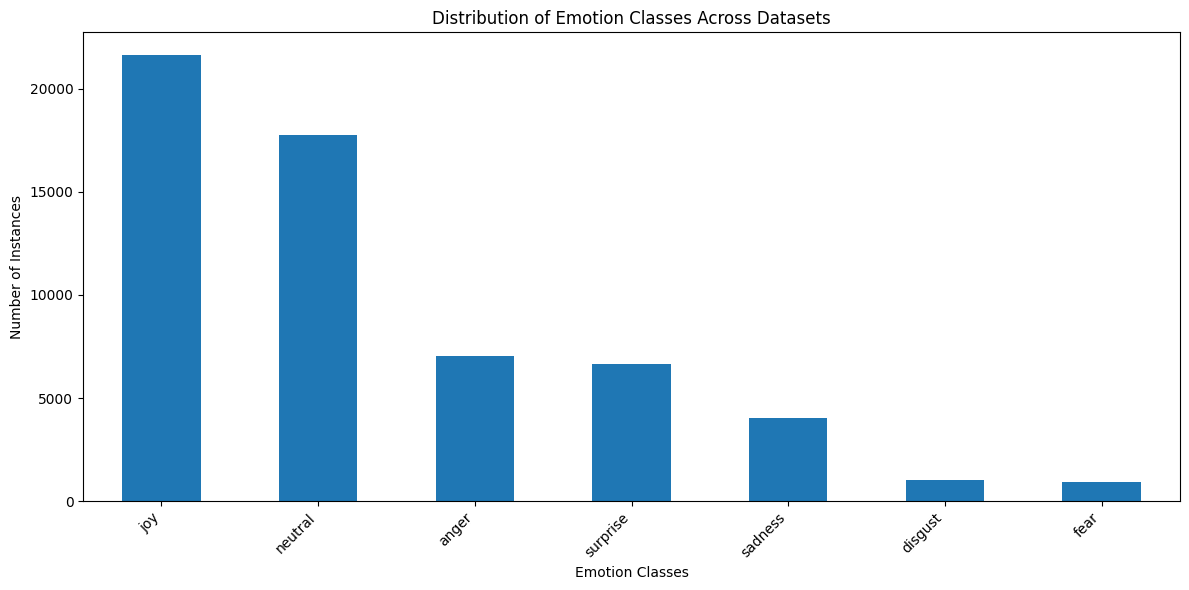

Train Dataset Emotion Counts:
joy         17335
neutral     14193
anger        5575
surprise     5362
sadness      3260
disgust       792
fear          726
Name: count, dtype: int64

Test Dataset Emotion Counts:
joy         2100
neutral     1786
anger        726
surprise     677
sadness      379
disgust      123
fear          98
Name: count, dtype: int64

Validation Dataset Emotion Counts:
joy         2217
neutral     1766
anger        717
surprise     624
sadness      390
fear         105
disgust       97
Name: count, dtype: int64


In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def count_emotions(dfs):
    all_emotions = []
    for df in dfs:
        all_emotions.extend([emotion for emotions in df['grouped_classes'] for emotion in emotions])
    
    return pd.Series(all_emotions).value_counts()

# count emotions across train, test, and validation DataFrames
emotion_counts = count_emotions([train_df, test_df, val_df])

plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotion Classes Across Datasets')
plt.xlabel('Emotion Classes')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Train Dataset Emotion Counts:")
print(count_emotions([train_df]))
print("\nTest Dataset Emotion Counts:")
print(count_emotions([test_df]))
print("\nValidation Dataset Emotion Counts:")
print(count_emotions([val_df]))

In [20]:
# dropping label and classes column

train_df = train_df.drop(columns=['label', 'classes'])
test_df = test_df.drop(columns=['label', 'classes'])
val_df = val_df.drop(columns=['label', 'classes'])

In [21]:
# convert list to string for one-hot encoding
train_df['grouped_classes'] = train_df['grouped_classes'].apply(lambda x: ','.join(x))
test_df['grouped_classes'] = test_df['grouped_classes'].apply(lambda x: ','.join(x))
val_df['grouped_classes'] = val_df['grouped_classes'].apply(lambda x: ','.join(x))


# one hot encoding
one_hot_train_df = train_df['grouped_classes'].str.get_dummies(sep=',')
one_hot_test_df = test_df['grouped_classes'].str.get_dummies(sep=',')
one_hot_val_df = val_df['grouped_classes'].str.get_dummies(sep=',')

train_df = pd.concat([train_df, one_hot_train_df], axis=1)
test_df = pd.concat([test_df, one_hot_test_df], axis=1)
val_df = pd.concat([val_df, one_hot_val_df], axis=1)

train_df = train_df.drop(columns=['grouped_classes'])
test_df = test_df.drop(columns=['grouped_classes'])
val_df = val_df.drop(columns=['grouped_classes'])

In [22]:
train_df.head(20)

,text,anger,disgust,fear,joy,neutral,sadness,surprise
0,My favourite food is anything I didn't have to cook myself.,0,0,0,0,1,0,0
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",0,0,0,0,1,0,0
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,0,0,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,0,0,0,1,0,0,0
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,0,0,0,1,0,0,0
8,Damn youtube and outrage drama is super lucrative for reddit,0,0,0,1,0,0,0
9,It might be linked to the trust factor of your friend.,0,0,0,0,1,0,0


In [23]:
train_df.to_csv('newTrain.csv', index=False)
test_df.to_csv('newTest.csv', index=False)
val_df.to_csv('newVal.csv', index=False)

In [24]:
train_df = pd.read_csv('newTrain.csv')
test_df = pd.read_csv('newTest.csv')
val_df = pd.read_csv('newVal.csv')

In [25]:
train_df.head(20)

# Text anomalies:
# 1. Words surrounded by brackets ([NAME], [RELIGION], etc)
# 2. Words that start with slash (/jk, /e)
# 3. Reddit subreddits (r/AskReddit, r/relationships)

,text,anger,disgust,fear,joy,neutral,sadness,surprise
0,My favourite food is anything I didn't have to cook myself.,0,0,0,0,1,0,0
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",0,0,0,0,1,0,0
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0
3,To make her feel threatened,0,0,1,0,0,0,0
4,Dirty Southern Wankers,1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.,0,0,0,0,0,0,1
6,Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝,0,0,0,1,0,0,0
7,We need more boards and to create a bit more space for [NAME]. Then we’ll be good.,0,0,0,1,0,0,0
8,Damn youtube and outrage drama is super lucrative for reddit,0,0,0,1,0,0,0
9,It might be linked to the trust factor of your friend.,0,0,0,0,1,0,0


In [26]:
def lower_case(text):
    return text.lower()

def remove_brackets(text):
    return re.sub(r'\[.*?\]', '', text)

def remove_slash(text):
    return re.sub(r'\/[a-z]*', '', text)

def remove_subreddits(text):
    return re.sub(r'r/[a-zA-Z]*', '', text)

def remove_non_alphabets(text):
    return ''.join([char for char in text if char.isalpha() or char.isspace()])

def custom_preprocessing(text):
    text = lower_case(text)
    text = remove_brackets(text)
    text = remove_slash(text)
    text = remove_subreddits(text)
    return text

def preprocess_text(text, stop_words):
    text = custom_preprocessing(text)
    tokens = gensim.utils.simple_preprocess(text)
    
    # removing stopwords and em
    tokens = [i for i in tokens if i not in stop_words]
    return tokens


stop_words = set(nltk.corpus.stopwords.words('english'))

train_df['tokens'] = train_df['text'].progress_apply(preprocess_text, args=(stop_words,))
test_df['tokens'] = test_df['text'].progress_apply(preprocess_text, args=(stop_words,))
val_df['tokens'] = val_df['text'].progress_apply(preprocess_text, args=(stop_words,))

train_df.head()

100%|██████████| 5424/5424 [00:00<00:00, 70631.04it/s]


,text,anger,disgust,fear,joy,neutral,sadness,surprise,tokens
0,My favourite food is anything I didn't have to cook myself.,0,0,0,0,1,0,0,"[favourite, food, anything, cook]"
1,"Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead",0,0,0,0,1,0,0,"[everyone, think, hes, laugh, screwing, people, instead, actually, dead]"
2,WHY THE FUCK IS BAYLESS ISOING,1,0,0,0,0,0,0,"[fuck, bayless, isoing]"
3,To make her feel threatened,0,0,1,0,0,0,0,"[make, feel, threatened]"
4,Dirty Southern Wankers,1,0,0,0,0,0,0,"[dirty, southern, wankers]"


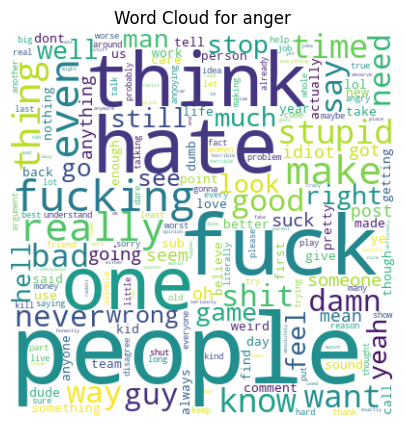

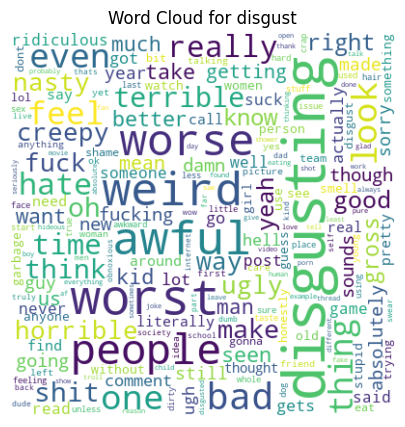

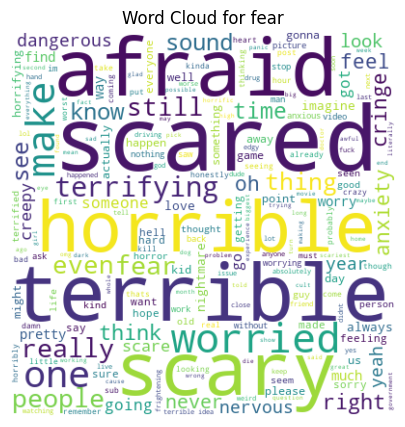

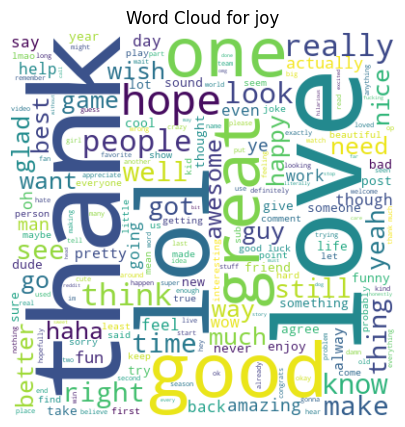

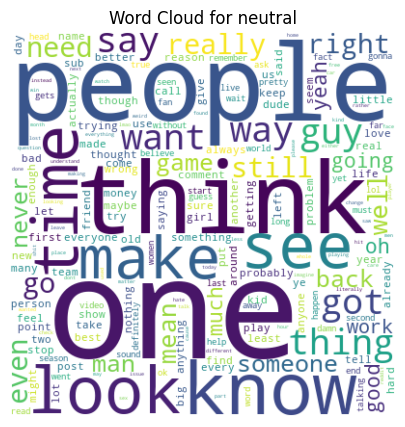

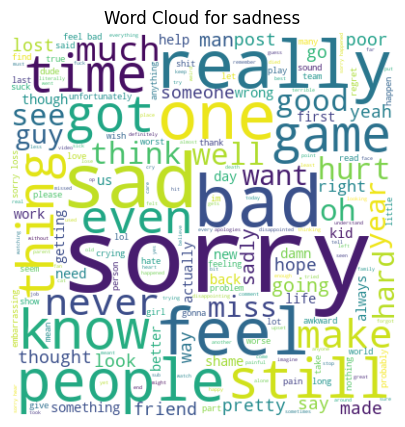

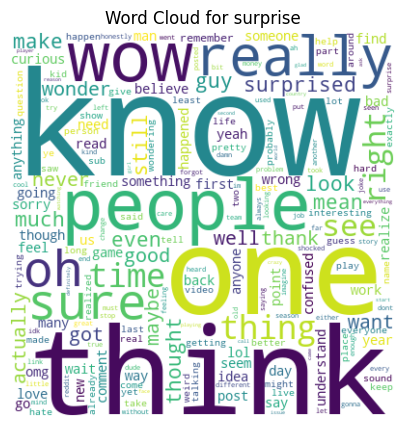

No text data available for tokens


In [27]:
def generate_wordcloud(text_data, class_name):
    # combining all text entries into a single string
    combined_text = ' '.join(text_data)
    
    if combined_text.strip():  # check if combined_text is not empty
        wordcloud = WordCloud(width=400, height=400, background_color='white').generate(combined_text)
        
        # display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for {class_name}")
        plt.show()
    else:
        print(f"No text data available for {class_name}")

for class_name in train_df.columns[1:]:
    class_text = train_df[train_df[class_name] == 1]['tokens'].apply(lambda x: ' '.join(x))
    generate_wordcloud(class_text, class_name)

For the anger wordcloud, some common words are "never", "fucking", "think", "people", and "hate".

The disgust wordcloud includes words like "awful", "worse", "disgusting", "nasty", and "weird".

The fear wordcloud features words such as "afraid", "scared", "scary", "horrible", and "terrible".

The joy wordcloud contains positive words like "good", "thank", "lol", "love", and "great".

For the neutral class wordcloud, contains a more general words without a emotional context like "people", "look", "know", "make", "one", and "time".

The sadness wordcloud contains sad words like "sorry", "sad", "bad", "really".

Finally, the surprise class wordcloud features words like "wow", "really", "wonder", and "know".

In [28]:
# joining each tokens into whole sentence

train_df['text'] = train_df['tokens'].apply(lambda x: ' '.join(x))
test_df['text'] = test_df['tokens'].apply(lambda x: ' '.join(x))
val_df['text'] = val_df['tokens'].apply(lambda x: ' '.join(x))

train_df = train_df.drop(columns=['tokens'])
test_df = test_df.drop(columns=['tokens'])
val_df = val_df.drop(columns=['tokens'])

train_df.head()

,text,anger,disgust,fear,joy,neutral,sadness,surprise
0,favourite food anything cook,0,0,0,0,1,0,0
1,everyone think hes laugh screwing people instead actually dead,0,0,0,0,1,0,0
2,fuck bayless isoing,1,0,0,0,0,0,0
3,make feel threatened,0,0,1,0,0,0,0
4,dirty southern wankers,1,0,0,0,0,0,0


In [34]:
# vectorizing the train, test, and validation dataset

tfidf = TfidfVectorizer()

X_train_vec = tfidf.fit_transform(train_df['text'])
X_test_vec = tfidf.transform(test_df['text'])
X_val_vec = tfidf.transform(val_df['text'])

# 

y_train = train_df.drop(columns=['text'])
y_test = test_df.drop(columns=['text'])
y_val = val_df.drop(columns=['text'])

In [35]:
print(X_train_vec.shape, y_train.shape)  # Confirm shapes are correct
print(X_test_vec.shape, y_test.shape)
print(X_val_vec.shape, y_val.shape)

(43297, 25193) (43297, 7)
(5422, 25193) (5422, 7)
(5424, 25193) (5424, 7)


In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the model
input_dim = 25193  # Number of features in the TF-IDF vectors
output_dim = 7     # Number of labels

model = Sequential([
    Dense(512, input_dim=input_dim, activation='relu'),  # First hidden layer
    Dropout(0.3),                                        # Dropout for regularization
    Dense(256, activation='relu'),                      # Second hidden layer
    Dropout(0.3),                                        # Dropout for regularization
    Dense(output_dim, activation='sigmoid')             # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summarize the model
model.summary()

# Train the model
history = model.fit(
    X_train_vec.toarray(),  # Convert sparse matrix to dense if using TF-IDF
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_vec.toarray(), y_val)
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_vec.toarray(), y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


c:\Python\environments\natural_language_processing\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │    12,899,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,032,455 (49.71 MB)

 Trainable params: 13,032,455 (49.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.4806 - loss: 0.3573 - val_accuracy: 0.6071 - val_loss: 0.2678
Epoch 2/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.7062 - loss: 0.2140 - val_accuracy: 0.5920 - val_loss: 0.2805
Epoch 3/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.7992 - loss: 0.1528 - val_accuracy: 0.5704 - val_loss: 0.3165
Epoch 4/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.8608 - loss: 0.1056 - val_accuracy: 0.5584 - val_loss: 0.3809
Epoch 5/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.9007 - loss: 0.0706 - val_accuracy: 0.5435 - val_loss: 0.4498
Epoch 6/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.9187 - loss: 0.0489 - val_accuracy: 0.5393 - val_loss: 0.5137
Epoch 7/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.9293 - loss: 0.0364 - val_accuracy: 0.5352 - val_loss: 0.5912
Epoch 8/10
677/677 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.9349 - loss: 0.0272 - 

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Example string to test the model
test_string = "tomorrow i have a presentation and im very nervous"

# Assuming you have already fitted the TF-IDF vectorizer on your training data
# You should have used the same vectorizer during training

# Transform the test string into the TF-IDF vector format
test_vec = tfidf.transform([test_string]).toarray()

# Make prediction using the trained model
predictions = model.predict(test_vec)

# Output the predictions for each label
print("Predicted probabilities for each label:", predictions)

# Convert probabilities to binary predictions (threshold of 0.5)
binary_predictions = (predictions > 0.5).astype(int)
print("Binary predictions for each label:", binary_predictions)

#anger	disgust	fear	joy	neutral	sadness	surprise

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicted probabilities for each label: [[1.0068959e-03 1.0158730e-04 9.9995756e-01 4.2889528e-06 6.8778240e-07
  2.6148269e-03 7.9782199e-05]]
Binary predictions for each label: [[0 0 1 0 0 0 0]]
